In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
import pickle
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

Mounted at /content/drive


# Step 1: Offline training

In [ ]:
UNI_ID = 'yy3414'

# Load data
taxonomy = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/taxonomy_engagement_data.csv')
to_predict_on = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/to_predict_on.csv')
content = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/content.csv')

In [ ]:
taxonomy.head()

,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
0,156773,9e11c362bc3d3572970b973d5cd86c073da358b6f9bcea...,129671,"{""controller"": ""ALPHA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1717.0,1.200000e+01,20.0,10.0,The greatest obstacle to being heroic is the d...,The greatest obstacle to being heroic is the d...,salvador_dali,Nathaniel Hawthorne,HumanTxt2Img,StableDiffusion,1.4,NaN
1,379473,600b4cdf20cc06a7b5a5cca5f7464296861815519af6d8...,107234,"{""controller"": ""DELTA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,417.0,1.224198e+09,75.0,10.0,the edge of the world has a view of our starry...,the edge of the world has a view of our starry...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN
2,184090,7a20311cf7a4b222d436424480bc65dd0f9d2cefcbbb1f...,87998,"{""controller"": ""CHARLIE""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1635.0,2.147484e+09,75.0,7.0,"Pixelart of a pirates battles in the ocean, vo...","Pixelart of a pirates battles in the ocean, vo...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN
3,70517,38b83caefa1ef26940f1d07bd4ec94c60809b0f88f2118...,107674,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,5292.0,1.625506e+09,75.0,8.0,star wars with lord Rihanna profile picture by...,star wars with lord Rihanna profile picture by...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN
4,433734,04a8708c3a481ced13845a30de522486895de0592222c2...,90424,"{""controller"": ""ECHO""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,2000.0,4.020473e+08,75.0,7.0,"cinematic view of a dreamy cloudscape, tim hil...","cinematic view of a dreamy cloudscape, tim hil...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


In [ ]:
to_predict_on.head()

,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
0,486946,6d05621ab7cb7b4fb796ca2ffbe1a141e0d4319d3deb6a...,61834,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,1,NaN,1.300000e+01,75.0,8.0,"She strokes his sweating head again, touches h...","She strokes his sweating head again, touches h...",movie: Gandh,Gandh,HumanTxt2Img,StableDiffusion,1.4,NaN
1,486907,6d05621ab7cb7b4fb796ca2ffbe1a141e0d4319d3deb6a...,208662,"{""controller"": ""RANDOM_TEXT""}",Text,NaN,0,0,3283.0,NaN,NaN,NaN,Write a song lyric about the problems of the w...,Write a song lyric about the problems of the w...,noir,NaN,Text2Text,Gemma,2B,"The city's a graveyard, shadows crawlin' deep,..."
2,486926,6d05621ab7cb7b4fb796ca2ffbe1a141e0d4319d3deb6a...,39318,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,1,NaN,1.200000e+01,75.0,4.0,The cell door opens and the hostage train of W...,The cell door opens and the hostage train of W...,movie: Natural-Born-Killers,Natural-Born-Killers,HumanTxt2Img,StableDiffusion,1.4,NaN
3,487166,6d05621ab7cb7b4fb796ca2ffbe1a141e0d4319d3deb6a...,117660,"{""controller"": ""RANDOM""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1698.0,8.000000e+00,20.0,10.0,there is probably a high volume and variety of...,there is probably a high volume and variety of...,studio,r/Showerthoughts,HumanTxt2Img,StableDiffusion,1.4,NaN
4,486976,6d05621ab7cb7b4fb796ca2ffbe1a141e0d4319d3deb6a...,89719,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,1.179432e+09,75.0,7.0,a cute seven year old boy with short tousled b...,a cute seven year old boy with short tousled b...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


In [ ]:
content.head()

,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
0,128522,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,11.0,50.0,8.0,Medieval It's so simple to be wise. Just think...,It's so simple to be wise. Just think of somet...,medieval,Sam Levenson,HumanTxt2Img,StableDiffusion,1.4,NaN
1,59744,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,8.0,75.0,10.0,Marc and Rebecca are on an affluent suburban s...,Marc and Rebecca are on an affluent suburban s...,movie: Bling-Ring-The,Bling-Ring-The,HumanTxt2Img,StableDiffusion,1.4,NaN
2,203817,Text,NaN,NaN,NaN,NaN,Create a dialogue between two people about lif...,Create a dialogue between two people about lif...,mystical,NaN,Text2Text,Gemma,2B,"""Oh, I believe I've heard it all before,"" quip..."
3,183075,Text,NaN,NaN,NaN,NaN,Write a children's story about artificial inte...,Write a children's story about artificial inte...,christmas-y,NaN,Text2Text,Claude,3.5 Sonnet,"On a snowy Christmas Eve, little Suzy unwrappe..."
4,178795,Text,NaN,NaN,NaN,NaN,Write a children's story about artificial inte...,Write a children's story about artificial inte...,surreal,NaN,Text2Text,GPT,3.5-turbo,"Once upon a time in a magical realm, there was..."


In [ ]:
def generate_embeddings(data, n_components=100):
    data.fillna({'msEngagement': 0}, inplace=True)
    data_clean = data.groupby(['user_id', 'content_id']).agg({'msEngagement': 'sum', 'is_like': 'sum', 'is_dislike': 'sum'}).reset_index()
    scaler = MinMaxScaler()
    data_clean[['msEngagement']] = scaler.fit_transform(data_clean[['msEngagement']])
    data_clean['interaction'] = data_clean['is_like'] - data_clean['is_dislike'] + data_clean['msEngagement']
    interaction_matrix = data_clean.pivot_table(index='user_id', columns='content_id', values='interaction', fill_value=0)
    svd = TruncatedSVD(n_components=n_components)
    user_embeddings = svd.fit_transform(interaction_matrix)
    item_embeddings = svd.components_.T
    item_embeddings_df = pd.DataFrame({'content_id': interaction_matrix.columns.tolist(), 'embedding': list(item_embeddings)})
    user_embeddings_df = pd.DataFrame({'user_id': interaction_matrix.index.tolist(), 'embedding': list(user_embeddings)})
    return user_embeddings_df, item_embeddings_df

In [ ]:
taxonomy_engage_user_embeddings, taxonomy_engage_item_embeddings = generate_embeddings(taxonomy, 100)
print(taxonomy_engage_user_embeddings.shape)
print(taxonomy_engage_item_embeddings.shape)

(176, 2)
(67884, 2)


In [ ]:
from transformers import BertModel, BertTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(prompts):
    embeddings = []
    for index, row in prompts.iterrows():
        content_id = row['content_id']
        prompt = row['prompt']
        inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to(device)
        outputs = model(**inputs)
        prompt_embedding = torch.mean(outputs.last_hidden_state, dim=1).cpu().detach().numpy()
        temp = pd.DataFrame({'content_id': content_id, 'embedding': list(prompt_embedding)})
        embeddings.append(temp)
    return embeddings

taxonomy_bert_embeddings = get_bert_embeddings(taxonomy.groupby('content_id')['prompt'].last().reset_index())


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
taxonomy_bert_embeddings = pd.concat(taxonomy_bert_embeddings)

In [ ]:
def get_reduced_embeddings(engage_embeddings, bert_embeddings):
    combined_embeddings = engage_embeddings.merge(bert_embeddings, on='content_id', how='left')
    combined_embeddings['combined_embedding'] = combined_embeddings.apply(lambda row: np.concatenate((row['embedding_x'], row['embedding_y'])), axis=1)
    svd = TruncatedSVD(n_components=128)
    combined_embedding_array = np.vstack(combined_embeddings['combined_embedding'].values)
    reduced_embeddings = svd.fit_transform(combined_embedding_array)
    reduced_embeddings_df = pd.DataFrame({'content_id': combined_embeddings['content_id'], 'embedding': list(reduced_embeddings)})
    return reduced_embeddings_df

In [ ]:
reduced_embeddings_df = get_reduced_embeddings(taxonomy_engage_item_embeddings, taxonomy_bert_embeddings)

In [ ]:
# Save the embeddings with the UNI_ID in the filename
with open(f'/content/drive/MyDrive/Colab Notebooks/{UNI_ID}_offline_data.pkl', 'wb') as f:
  pickle.dump({'user_embeddings': taxonomy_engage_user_embeddings, 'item_embeddings': reduced_embeddings_df}, f)

# Step 2: Pre-computing



In [ ]:
def get_precomputed_data():

    # Load embeddings if you did offline training
    with open(f'/content/drive/MyDrive/Colab Notebooks/{UNI_ID}_offline_data.pkl', 'rb') as f:
        data = pickle.load(f)

    user_embeddings = data['user_embeddings']
    item_embeddings = data['item_embeddings']

    return user_embeddings, item_embeddings

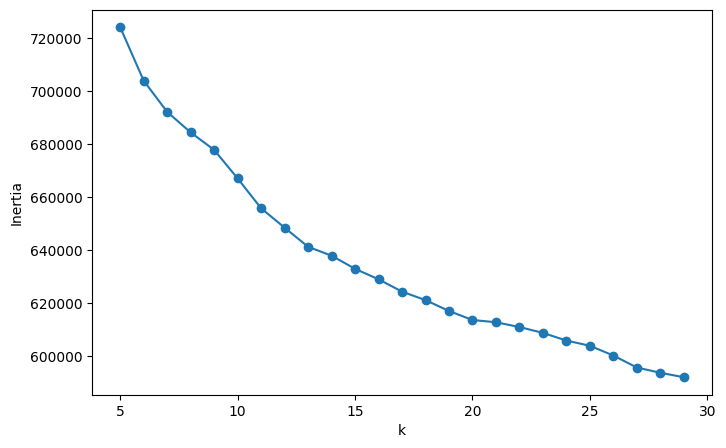

In [ ]:
# Other precomputing, like alternating least squares, or clustering, etc
user_embeddings, item_embeddings = get_precomputed_data()
# clustering doesn't work well
inertia_values = []
k_values = range(5, 30)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(item_embeddings['embedding'].tolist())
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

# Step 3: Online candidate generating

Given a user id with all their data, return a list of new content

Number of content is how many pieces of content they should return. Offset is like a page number. So if called twice first with offset 0 and then offset 50 (both times 50 number of content), we shouldn’t get the same results twice.

In [ ]:
# Load precomputed data, it can be embeddings, or clustering result, etc
user_embeddings, item_embeddings = get_precomputed_data()

def get_content(df, user_id, number_of_content, offset=0):
    predict_engage_user_embeddings, predict_engage_item_embeddings = generate_embeddings(df, 100)
    predict_bert_embeddings = pd.concat(get_bert_embeddings(df.groupby('content_id')['prompt'].last().reset_index()))
    predict_reduced_embeddings = get_reduced_embeddings(predict_engage_item_embeddings, predict_bert_embeddings)

    existing_content = df[df['user_id'] == user_id]['content_id'].tolist()
    present_in_content = set(content.content_id)

    similarity_scores = cosine_similarity(predict_reduced_embeddings['embedding'].tolist(), item_embeddings['embedding'].tolist())
    similarity_scores = np.mean(similarity_scores, axis=0)
    sorted_indices = np.argsort(similarity_scores)[::-1]
    sorted_content_ids = [item_embeddings.iloc[i]['content_id'] for i in sorted_indices]
    sorted_content_ids = [item for item in sorted_content_ids if (item not in existing_content) and (item in present_in_content)]

    return sorted_content_ids[offset:offset + number_of_content]

In [ ]:
# Example usage of the function
user_id = '6d05621ab7cb7b4fb796ca2ffbe1a141e0d4319d3deb6a05322b9de85d69b923'

recommended_content = get_content(to_predict_on, user_id=user_id, number_of_content=500, offset=0)
print("Recommended Content IDs:", recommended_content)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


Recommended Content IDs: [64799, 44833, 36664, 97506, 78696, 60557, 51743, 36186, 48552, 67262, 33579, 62754, 29244, 47724, 46927, 44151, 31454, 40479, 78666, 54281, 67263, 49679, 69891, 77179, 64741, 53819, 35235, 38332, 68001, 52743, 51774, 47461, 32118, 32373, 32558, 75372, 33895, 29132, 60886, 73478, 58093, 74555, 43105, 42368, 34731, 65715, 71290, 33099, 37227, 36548, 78318, 75701, 60803, 38535, 43952, 60164, 39846, 79556, 47946, 68847, 50055, 41637, 68007, 78687, 78664, 35363, 50136, 41849, 73451, 53179, 72780, 34736, 71537, 53182, 43799, 29109, 65713, 81364, 65903, 58017, 33758, 52134, 75353, 40517, 57613, 37591, 33280, 58587, 58361, 68770, 53778, 42828, 69481, 94507, 31820, 35237, 76571, 37295, 37252, 60087, 29271, 52442, 73117, 62095, 77215, 36071, 62575, 29226, 54296, 62572, 101183, 67786, 76460, 33517, 65875, 52595, 46013, 35229, 61161, 66020, 33120, 74292, 40802, 71516, 31484, 50746, 52716, 30132, 73131, 69334, 59765, 57973, 28654, 31673, 70091, 58928, 50873, 63270, 34307, 

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/yy3414_recommended_content.txt', 'w') as f:
    for item in recommended_content:
        f.write("%s\n" % item)

In [ ]:
# from IPython.display import display, Image, clear_output

# def display_content(content_id):
#     """Displays a single content piece."""
#     temp = content[content['content_id'] == content_id].iloc[0]

#     # Display content information
#     print(f"**Content ID:** {content_id}")
#     display(pd.DataFrame(temp).T)  # Use DataFrame for better table formatting
#     if temp['media_type']=='Image':
#         display(Image(url=temp['s3_url'], width=300, height=300))

# for content_id in recommended_content:
#     display_content(content_id)